## This script is for the growth simulation of different carbon sources
The experimental data is used from the iMK735 model

In [3]:
# imports
import cobra
from cobra.flux_analysis import pfba

import yaml
import pandas as pd

## calculate the confusion matrix from this column and plot it
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

import sys # append path

sys.path.append('../scripts/')
import helperFunction as hf

# config
config_name = 'model_config'
config_path = f'../config/{config_name}.yaml'

# load config
with open(config_path, 'r') as file:
    config = yaml.safe_load(file)

### Show the experimental table from the supplementary data of the paper from [iMK735](https://bmcsystbiol.biomedcentral.com/articles/10.1186/s12918-015-0217-4#additional-information)

In [39]:
## show the table (experimental data)
growth_table = pd.read_csv('../../workflow/data/further_studies/growth_simulation/experimental_growth_table_Yli.csv' , sep=config['seperator']) # not available anymore
print('Number of carbon sources: ', len(growth_table)) # 25
growth_table.head()
# translate + -> 1 and - -> 0
growth_table['experimental_result'] = growth_table['experiment'].replace('+', 1).replace('-', 0)

Number of carbon sources:  23


In [54]:
# function for plotting the confusion matrix
def plot_confision_matrix(growth_simulation, model_name):
    """Compute and print the confusion matrix of the growth simulation and the experimental results."""
    #Generate the confusion matrix
    tn, fp, fn, tp = confusion_matrix(growth_simulation['experimental_result'], growth_simulation[f'{model_name}_simulation']).ravel()
    cf_matrix = confusion_matrix(growth_simulation['experimental_result'], growth_simulation[f'{model_name}_simulation'])

    ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), fmt='.2%', annot=True, cmap='Blues')
    ax.set_title(f'Growth confusion Matrix of {model_name}\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

    # Caluculate the numbers
    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)
    negative_üredictive_value = tn/(tn+fn)
    accuracy = (tp+tn)/(tp+tn+fp+fn)

    # Print the results
    print(f'Sensitivity: {sensitivity.round(2)}')
    print(f'Specificity: {specificity.round(2)}')
    print(f'Negative Predictive Value: {negative_üredictive_value.round(2)}')
    print(f'Accuracy: {accuracy.round(2)}')


In [7]:
growth_table

,carbon_source,iMK735_publication,experiment,experimental_result
0,alkanes,+,+,1
1,arabinitol,-,-,0
2,L-arabinose,-,-,0
3,D-arabinose,-,-,0
4,citrate,+,+,1
5,D-galactose,+,+,1
6,D-glucosamine,+,-,0
7,D-glucose,+,+,1
8,ethanol,+,+,1
9,fatty acids,+,+,1


### iMK735

In [40]:
# load model
iMK735_model_path = config['models']['yliMK735']
iMK735_model = cobra.io.read_sbml_model(iMK735_model_path)
# set objective
iMK735_model.objective = 'biomass_C'
model_name = 'iMK735'

No objective in listOfObjectives
No objective coefficients in model. Unclear what should be optimized


#### Find the exchange reactions

In [41]:
## find the exchange reactions in iMK735
carbonSources = growth_table['carbon_source'].tolist()
# print(len(carbonSources)) # 25

# # iterate all exchange reactions and print them
# for rxn in iMK735_model.exchanges:
#     print(rxn.id, rxn.name, rxn.reaction)

for rxn in iMK735_model.boundary:
    print(rxn.id, rxn.name, rxn.reaction)

# # find the exchange reactions
# foud_exchanges = 0
# exchages_dict = {}
# for rxn in iMK735_model.exchanges:
#     for cs in carbonSources:
#         try:
#             carbon_source = cs.split('-')[1]
#         except:
#             carbon_source = cs
#         print(carbon_source)
#         if carbon_source in rxn.name.lower():
#             foud_exchanges += 1
#             exchages_dict[cs] = (rxn.id, rxn.name)
#             print(rxn.id, rxn.name, rxn.reaction)
# print(foud_exchanges) # 27 
# # found L-arabinose and D-arabinose as L-arabinose exchange
# print(exchages_dict)

## fake check the exchange dict

checked_exchange_dict = {
    'alkanes': ('EX_alc(e)', 'alcane exchange YL'), # found
    'arabinitol': ('EX_abt(e)', 'L Arabinitol exchange'), 
    'L-arabinose': ('EX_arab_L(e)', 'L Arabinose exchange'), 
    'D-arabinose': ('EX_arab_D(e)','D Arabinose exchange'), # found
    'citrate': ('EX_cit(e)', 'Citrate exchange'), 
    'D-galactose': ('EX_gal(e)', 'D Galactose exchange'), 
    'D-glucosamine': ('EX_gam6p(e)', 'D Glucosamine 6 phosphate exchange'), 
    'D-glucose': ('EX_glc(e)', 'D Glucose exchange'), 
    'ethanol': ('EX_etoh(e)', 'Ethanol exchange'),
    'fatty acids': ('EX_ttdca(e)','tetradecanoate n C140 exchange'), # found (https://pubchem.ncbi.nlm.nih.gov/compound/Tetradecanoate: ttdca[e])
    'glycerol': ('EX_glyc(e)', 'Glycerol exchange'), 
    'lactate': ('EX_lac_L(e)', 'L Lactate exchange'), 
    'L-sorbose': ('EX_srb_L(e)', 'L Sorbose exchange'), 
    'maltose': ('EX_malt(e)', 'Maltose exchange'), 
    'melibiose': ('EX_melib(e)', 'Melibiose exchange'), 
    'myo-inositol': ('EX_inost(e)', 'myo Inositol exchange'), 
    'ribose': ('EX_rib_D(e)', 'D Ribose exchange'), 
    'succinate': ('EX_succ(e)', 'Succinate exchange'), 
    'sucrose': ('EX_sucr(e)', 'Sucrose exchange'),
    'TAG': ('LDparticle_SC_e_tp', 'LDparticle SC e tp'), # found by looking at the list of metabolites produced by this metabolite (it is transported into the cell and then transformed into triglyc_SC[c] which is a TAG (formula of triglyc: C5160H9566O600))
    'trehalose': ('trehalose_c_tp', 'trehalose c tp'), 
    'xylitol': ('EX_xylt(e)', 'Xylitol exchange'),
    'xylose': ('EX_xyl_D(e)', 'D Xylose exchange'), 
}

# # looking for a fatty acids exchange reaction 
# ttdca = iMK735_model.metabolites.get_by_id('ttdca[e]')
# ttdca

# # looking for a TAG exchange reaction
# LDparticle_SC_c = iMK735_model.metabolites.get_by_id('LDparticle_SC_c[e]')
# LDparticle_SC_c



EX_13BDglcn(e) 1 3 beta D Glucan exchange 13BDglcn[e] --> 
EX_4abut(e) 4 Aminobutanoate exchange 4abut[e] --> 
EX_5aop(e) 5 Amino 4 oxopentanoate exchange 5aop[e] --> 
EX_8aonn(e) 8 Amino 7 oxononanoate exchange 8aonn[e] --> 
EX_abt(e) L Arabinitol exchange abt[e] --> 
EX_ac(e) Acetate exchange ac[e] --> 
EX_acald(e) Acetaldehyde exchange acald[e] --> 
EX_ade(e) Adenine exchange ade[e] --> 
EX_adn(e) Adenosine exchange adn[e] --> 
EX_akg(e) 2 Oxoglutarate exchange akg[e] --> 
EX_ala_L(e) L Alanine exchange ala_L[e] --> 
EX_alc(e) alcane exchange YL alc[e] --> 
EX_alltn(e) Allantoin exchange alltn[e] --> 
EX_alltt(e) Allantoate exchange alltt[e] --> 
EX_amet(e) S Adenosyl L methionine exchange amet[e] --> 
EX_arab_D(e) D Arabinose exchange arab_D[e] --> 
EX_arab_L(e) L Arabinose exchange arab_L[e] --> 
EX_arg_L(e) L Arginine exchange arg_L[e] --> 
EX_asn_L(e) L Asparagine exchange asn_L[e] --> 
EX_asp_L(e) L Aspartate exchange asp_L[e] --> 
EX_buca(e) butanoate exchange YL buca[e] --> 


In [47]:
# # analysing TAG reaction
# for met in iMK735_model.metabolites:
#     if 'triglyc' in met.name.lower():
#         print(met.id, met.name, met.formula, met.compartment)

# # what is happening to LDparticle_SC_c[e]
# print('In the LDparticle_SC_c[e]:')
# LDparticle_SC_c = iMK735_model.metabolites.get_by_id('LDparticle_SC_c[e]')
# for rxn in LDparticle_SC_c.reactions:
#     print(rxn.id, rxn.name, 'reaction: ', rxn.reaction)

# print('In the LDparticle_SC[c]:')
# # it is transported into the cytosol => LDparticle_SC
# LDparticle_SC_c = iMK735_model.metabolites.get_by_id('LDparticle_SC[c]')
# # print('LDparticle_SC_c formula: ', LDparticle_SC_c.formula) # None
# for rxn in LDparticle_SC_c.reactions:
#     print(rxn.id, rxn.name, rxn.reaction)

# print('In the triglyc_SC[c]:')
# # it forms triglyc_SC which is a tag triglyc_SC[c] <=> 0.01 LDparticle_SC[c]
# # => LDparticle_SC_c is a precursor of triglyc_SC and therefore a TAG
# triglyc_SC_c = iMK735_model.metabolites.get_by_id('triglyc_SC[c]')
# print('triglyc_SC_c formula: ', triglyc_SC_c.formula)

# # formation of LDp:
# LDp_form = iMK735_model.reactions.get_by_id('LDp_form')
# print(LDp_form.id, LDp_form.name, 'reaction: ' , LDp_form.reaction)


#### Compute if growth is possible

In [42]:
# # Prepare model: no carbon source uptake is allowed
# # look at the default growth: (if simple (1 carbon source == glucose) => remove glucose and set the other carbon sources accordingly)
# iMK735_model.summary()
# remove glucose uptake
iMK735_model.reactions.get_by_id('EX_glc(e)').lower_bound = 0
# set the biomass reaction to the biomass_C reaction
iMK735_biomass = 'biomass_C'
iMK735_model.reactions.get_by_id(iMK735_biomass).bounds = (0, 1000)
iMK735_model.objective = iMK735_biomass
try:
    iMK735_model.summary()
    print('feasible => something is wrong')
except:
    print('infeasible => everything is fine')

# iterate over key and values of dict checked_exchange_dict:
growth_dict = {}
for carbon_source_name, (exchange_id, exchange_name) in checked_exchange_dict.items():
    with iMK735_model as model:
        print(carbon_source_name, (exchange_id, exchange_name))
        # get the exchange reaction
        exchange_reaction = model.reactions.get_by_id(exchange_id)
        print(exchange_reaction)
        # set the lower bound of the exchange reaction to -1
        exchange_reaction.lower_bound = -10
        # set the upper bound of the exchange reaction to 1000
        exchange_reaction.upper_bound = 1000
        # set biomass reaction bounds to 0, 1000
        model.reactions.get_by_id(iMK735_biomass).bounds = (0, 1000)
        # optimize the model
        try:
            solution = model.optimize()
            objective_value = solution.objective_value
            # solution = pfba(model)
            # objective_value = solution.fluxes[iMK735_biomass]
        except:
            objective_value = 0
        growth_possible = 1 if objective_value > 0 else 0
        # print the objective value
        print(f'Growth on {10}mmol/h uptake of {carbon_source_name} is predicted to be: ', objective_value)
        growth_dict[carbon_source_name] = (growth_possible, objective_value)

print(growth_dict)

infeasible => everything is fine
alkanes ('EX_alc(e)', 'alcane exchange YL')
EX_alc(e): alc[e] --> 
Growth on 10mmol/h uptake of alkanes is predicted to be:  1.4581722931171512
arabinitol ('EX_abt(e)', 'L Arabinitol exchange')
EX_abt(e): abt[e] --> 
Growth on 10mmol/h uptake of arabinitol is predicted to be:  0.0
L-arabinose ('EX_arab_L(e)', 'L Arabinose exchange')
EX_arab_L(e): arab_L[e] --> 
Growth on 10mmol/h uptake of L-arabinose is predicted to be:  0.0
D-arabinose ('EX_arab_D(e)', 'D Arabinose exchange')
EX_arab_D(e): arab_D[e] --> 
Growth on 10mmol/h uptake of D-arabinose is predicted to be:  0.0
citrate ('EX_cit(e)', 'Citrate exchange')
EX_cit(e): cit[e] --> 
Growth on 10mmol/h uptake of citrate is predicted to be:  0.3286430534731814
D-galactose ('EX_gal(e)', 'D Galactose exchange')
EX_gal(e): gal[e] --> 
Growth on 10mmol/h uptake of D-galactose is predicted to be:  0.9919846469281107
D-glucosamine ('EX_gam6p(e)', 'D Glucosamine 6 phosphate exchange')
EX_gam6p(e): gam6p[e] -->

/Users/ampholyt/miniconda3/envs/ma/lib/python3.8/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/Users/ampholyt/miniconda3/envs/ma/lib/python3.8/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/Users/ampholyt/miniconda3/envs/ma/lib/python3.8/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


Growth on 10mmol/h uptake of ethanol is predicted to be:  0.26801217458263144
fatty acids ('EX_ttdca(e)', 'tetradecanoate n C140 exchange')
EX_ttdca(e): ttdca[e] --> 
Growth on 10mmol/h uptake of fatty acids is predicted to be:  1.9125389880354084
glycerol ('EX_glyc(e)', 'Glycerol exchange')
EX_glyc(e): glyc[e] --> 
Growth on 10mmol/h uptake of glycerol is predicted to be:  0.5799711784683212
lactate ('EX_lac_L(e)', 'L Lactate exchange')
EX_lac_L(e): lac_L[e] --> 
Growth on 10mmol/h uptake of lactate is predicted to be:  -0.01759882281840912
L-sorbose ('EX_srb_L(e)', 'L Sorbose exchange')
EX_srb_L(e): srb_L[e] --> 
Growth on 10mmol/h uptake of L-sorbose is predicted to be:  -0.01759882281840912
maltose ('EX_malt(e)', 'Maltose exchange')
EX_malt(e): malt[e] --> 
Growth on 10mmol/h uptake of maltose is predicted to be:  -0.017598822818409212
melibiose ('EX_melib(e)', 'Melibiose exchange')
EX_melib(e): melib[e] --> 
Growth on 10mmol/h uptake of melibiose is predicted to be:  2.05216823833

/Users/ampholyt/miniconda3/envs/ma/lib/python3.8/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/Users/ampholyt/miniconda3/envs/ma/lib/python3.8/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/Users/ampholyt/miniconda3/envs/ma/lib/python3.8/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/Users/ampholyt/miniconda3/envs/ma/lib/python3.8/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/Users/ampholyt/miniconda3/envs/ma/lib/python3.8/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/Users/ampholyt/miniconda3/envs/ma/lib/python3.8/site-packages/cobra/u

Growth on 10mmol/h uptake of succinate is predicted to be:  0.3733069145526041
sucrose ('EX_sucr(e)', 'Sucrose exchange')
EX_sucr(e): sucr[e] --> 
Growth on 10mmol/h uptake of sucrose is predicted to be:  -0.017598822818409153
TAG ('LDparticle_SC_e_tp', 'LDparticle SC e tp')
LDparticle_SC_e_tp: 0.01 LDparticle_SC_c[e] --> 
Growth on 10mmol/h uptake of TAG is predicted to be:  -0.017598822818409153
trehalose ('trehalose_c_tp', 'trehalose c tp')
trehalose_c_tp:  --> tre_c[e]
Growth on 10mmol/h uptake of trehalose is predicted to be:  -0.017598822818409153
xylitol ('EX_xylt(e)', 'Xylitol exchange')
EX_xylt(e): xylt[e] --> 
Growth on 10mmol/h uptake of xylitol is predicted to be:  0.9470353426144487
xylose ('EX_xyl_D(e)', 'D Xylose exchange')
EX_xyl_D(e): xyl_D[e] --> 
Growth on 10mmol/h uptake of xylose is predicted to be:  0.8586867099973688
{'alkanes': (1, 1.4581722931171512), 'arabinitol': (0, 0.0), 'L-arabinose': (0, 0.0), 'D-arabinose': (0, 0.0), 'citrate': (1, 0.3286430534731814), '

In [76]:
# Understanding negative flux: ('lactate', 'L-sorbose', 'maltose', 'myo-inositol', 'sucrose', 'TAG', 'trehalose')
# iMK735_model.tolerance # 1e-07
growth_dict['lactate']
# abs(growth_dict['lactate']) < 1e-07

# # check bounds of biomass
# iMK735_model.reactions.get_by_id('biomass_C')

-0.01759882281840912

In [43]:
# translate growth_dict into a dataframe
growth_simulation_df = pd.DataFrame(growth_dict).T.rename_axis('carbon_source').reset_index()
growth_simulation_df.columns = ['carbon_source', f'{model_name}_simulation', f'{model_name}_growth_rate']
# growth_simulation_df.head()

# left join growth_df with the original dataframe growth_table
growth_simulation = pd.merge(growth_table, growth_simulation_df[['carbon_source', 'iMK735_simulation']], on='carbon_source', how='left')
growth_simulation

# my simulation and publication differ in 4 points:
# lactate, L-sorbose, TAG, trehalose (publication: 1, my_simulation: 0)

,carbon_source,iMK735_publication,experiment,experimental_result,iMK735_simulation
0,alkanes,+,+,1,1.0
1,arabinitol,-,-,0,0.0
2,L-arabinose,-,-,0,0.0
3,D-arabinose,-,-,0,0.0
4,citrate,+,+,1,1.0
5,D-galactose,+,+,1,1.0
6,D-glucosamine,+,-,0,1.0
7,D-glucose,+,+,1,1.0
8,ethanol,+,+,1,1.0
9,fatty acids,+,+,1,1.0


In [109]:
## analysing lactate, L-sorbose, TAG, trehalose again
# with iMK735_model as model:
#     lactate_rxn_id = checked_exchange_dict['lactate'][0] # 'EX_lac_L(e)'
#     lactate_rxn = model.reactions.get_by_id(lactate_rxn_id)
#     lactate_rxn.lower_bound = -10
#     lactate_rxn.upper_bound = 1000
#     print(model.optimize())

# # investigate the pathway of lactate
# print('Lactate pathway:')
# lactate_rxn = iMK735_model.reactions.get_by_id('EX_lac_L(e)')
# # lactate_rxn.reaction # lac_L[e] --> 
# lactate_met = iMK735_model.metabolites.get_by_id('lac_L[e]')
# lactate_met.reactions # EX_lac_L(e), L_LACt2r
# L_LACt2r = iMK735_model.reactions.get_by_id('L_LACt2r')
# L_LACt2r.reaction # 'h[e] + lac_L[e] <=> h[c] + lac_L[c]'
# # investigate lac_L[c] 
# lac_L_c = iMK735_model.metabolites.get_by_id('lac_L[c]')
# lac_L_c.reactions # lactate is a dead end metabolite


Lactate pathway:


frozenset({<Reaction L_LACt2r at 0x7fbb3bd988e0>})

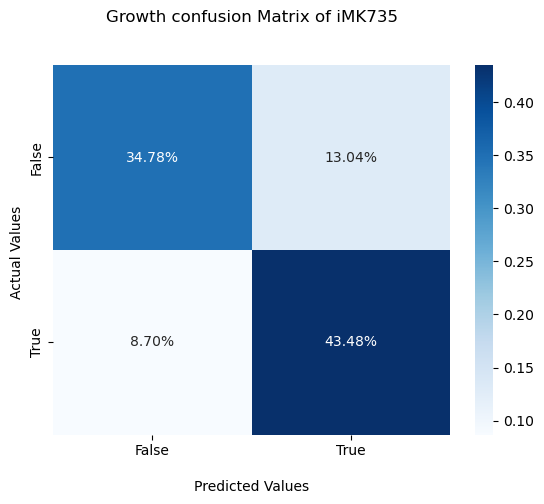

Sensitivity: 0.83
Specificity: 0.73
Negative Predictive Value: 0.8
Accuracy: 0.78


In [44]:
def print_confision_matrix(growth_simulation, model_name):
    """Compute and print the confusion matrix of the growth simulation and the experimental results."""
    #Generate the confusion matrix
    tn, fp, fn, tp = confusion_matrix(growth_simulation['experimental_result'], growth_simulation[f'{model_name}_simulation']).ravel()
    cf_matrix = confusion_matrix(growth_simulation['experimental_result'], growth_simulation[f'{model_name}_simulation'])

    ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), fmt='.2%', annot=True, cmap='Blues')
    ax.set_title(f'Growth confusion Matrix of {model_name}\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

    # Caluculate the numbers
    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)
    negative_üredictive_value = tn/(tn+fn)
    accuracy = (tp+tn)/(tp+tn+fp+fn)

    # Print the results
    print(f'Sensitivity: {sensitivity.round(2)}')
    print(f'Specificity: {specificity.round(2)}')
    print(f'Negative Predictive Value: {negative_üredictive_value.round(2)}')
    print(f'Accuracy: {accuracy.round(2)}')


### iYli21

In [45]:
# load model
iYli21_model_path = config['models']['yli21']
iYli21_model = cobra.io.read_sbml_model(iYli21_model_path)
print('iYli21_model')
glucose_exchange_reaction = 'R1070'
biomass_reaction = 'biomass_C'

model_name='iYli21'

# iYli21_model.summary()

# hf.mediumAnalysis(iYli21_model) # => Easy case (only glucose is active)

# restrict glucose growth
iYli21_model.reactions.get_by_id(glucose_exchange_reaction).bounds = (0, 1000)

# find exchange reactions



iYli21_model


In [46]:
## find exchange reactions
for rxn in iYli21_model.exchanges:
    met = list(rxn.metabolites)[0]
    print(rxn.id, rxn.name, rxn.reaction, met.name)

# # check if boundary and exchange are the same set of reactions
# exchanges = set([rxn.id for rxn in iYli21_model.exchanges])
# boundaries = set([rxn.id for rxn in iYli21_model.boundary])
# differeces = exchanges.symmetric_difference(boundaries)
# differeces
# R1373 = iYli21_model.reactions.get_by_id('R1373')
# R1373 #m1401[c]
# biomass_C = iYli21_model.reactions.get_by_id('biomass_C')
# biomass_C.reaction

empty_growth_dict = {
    'alkanes': ('', ''),
    'arabinitol': ('', ''),
    'L-arabinose': ('', ''),
    'D-arabinose': ('', ''),
    'citrate': ('', ''),
    'D-galactose': ('', ''),
    'D-glucosamine': ('', ''),
    'D-glucose': ('', ''),
    'ethanol': ('', ''),
    'fatty acids': ('', ''),
    'glycerol': ('', ''),
    'lactate': ('', ''),
    'L-sorbose': ('', ''),
    'maltose': ('', ''),
    'melibiose': ('', ''),
    'myo-inositol': ('', ''),
    'ribose': ('', ''),
    'succinate': ('', ''),
    'sucrose': ('', ''),
    'TAG': ('', ''),
    'trehalose': ('', ''),
    'xylitol': ('', ''),
    'xylose': ('', ''),
}

# # find the exchange reactions
# foud_exchanges = 0
# exchages_dict = {}
# for rxn in iYli21_model.exchanges:
#     for cs in empty_growth_dict:
#         try:
#             carbon_source = cs.split('-')[1]
#         except:
#             carbon_source = cs
#         print(carbon_source)
#         if carbon_source in rxn.name.lower():
#             foud_exchanges += 1
#             exchages_dict[cs] = (rxn.id, rxn.name)
#             print(rxn.id, rxn.name, rxn.reaction)
# print(foud_exchanges) 
# # found L-arabinose and D-arabinose as L-arabinose exchange
# print(exchages_dict)

R941 (1-3)-beta-D-glucan exchange m510[e] -->  (1-3)-beta-D-glucan_
R943 (R)-carnitine exchange m1069[e] -->  (R)-carnitine_C7H15NO3
R944 (R)-lactate exchange m1043[e] -->  (R)-lactate_C3H6O3
R945 (R)-mevalonate exchange m1018[e] -->  (R)-mevalonate_C6H12O4
R946 (R)-pantothenate exchange m1098[e] -->  (R)-pantothenate_C9H17NO5
R947 (R,R)-2,3-butanediol exchange m1020[e] -->  (R,R)-2,3-butanediol_ActiveX VT_ERROR:
R948 (S)-lactate exchange m1079[e] -->  (S)-lactate_C3H6O3
R949 (S)-malate exchange m1130[e] -->  (S)-malate_C4H6O5
R950 1-(sn-glycero-3-phospho)-1D-myo-inositol exchange m1053[e] -->  1-(sn-glycero-3-phospho)-1D-myo-inositol_C9H18O11P
R951 1-acylglycerophosphocholine exchange m1133[e] -->  1-acylglycerophosphocholine_C9H20NO7PR
R954 2'-deoxyadenosine exchange m1135[e] -->  2'-deoxyadenosine_C10H13N5O3
R955 2'-deoxyguanosine exchange m1137[e] -->  2'-deoxyguanosine_C10H13N5O4
R956 2'-deoxyinosine exchange m1139[e] -->  2'-deoxyinosine_C10H12N4O4
R957 2'-deoxyuridine exchange m

In [47]:
checked_exchange_dict = {
    'alkanes': ('', ''), # nothing found
    'arabinitol': ('R1198', 'L-arabinitol exchange'), 
    'L-arabinose': ('R1201', 'L-arabinose exchange'), 
    'D-arabinose': ('R1062', 'D-arabinose exchange'), 
    'citrate': ('R1045', 'citrate(3-) exchange'), 
    'D-galactose': ('R1066', 'D-galactose exchange'), 
    'D-glucosamine': ('R1992', 'D-glucosamine exchange'), 
    'D-glucose': ('R1070', 'D-glucose exchange'), 
    'ethanol': ('R1112', 'ethanol exchange'), 
    'fatty acids': ('R1288', 'palmitate exchange'), #is a fatty acid according to https://en.wikipedia.org/wiki/Palmitic_acid 
    'glycerol': ('R1141', 'glycerol exchange'), 
    'lactate': ('R948', '(S)-lactate exchange'), # not sure if (S) (L-lactate) or (R) (D-lactate) is correct
    'L-sorbose': ('R1229', 'L-sorbose exchange'), 
    'maltose': ('R1249', 'maltose exchange'), 
    'melibiose': ('R1713', 'melibiose exchange'),
    'myo-inositol': ('R1263', 'myo-inositol exchange'), 
    'ribose': ('R1072', 'D-ribose exchange'), 
    'succinate': ('R1330', 'succinate exchange'), 
    'sucrose': ('R1332', 'sucrose exchange'), 
    'TAG': ('', ''),  # nothing found in this model
    'trehalose': ('R1013', 'alpha,alpha-trehalose exchange'), # alpha alpha glucusidische Bindungen
    'xylitol': ('R1368', 'xylitol exchange'), 
    'xylose': ('R1074', 'D-xylose exchange'), 
}

In [29]:
# # looking for TAG
# # for rxn in iYli21_model.reactions:
# #     if 'tria' in rxn.name.lower():
# #         print(rxn.id, rxn.name, rxn.reaction)

# # m1399[c] triacylglycerol 
# m1399 = iYli21_model.metabolites.get_by_id('m1399[c]')
# m1399 # name: triglyceride_ActiveX VT_ERROR:
# m1640 = iYli21_model.metabolites.get_by_id('m1640[C_lp]')
# m1640 # name: triglyceride_ActiveX VT_ERROR

# # # check reactions of m1399
# # for rxn in m1399.reactions:
# #     print(rxn.id, rxn.name, rxn.reaction)
# #     # is synthesized in the cytosol or transportet in r or to the er membrane


# # check reactions of m1640
# for rxn in m1640.reactions:
#     print(rxn.id, rxn.name, rxn.reaction)
#     # a reaction called tag transport: m1634

# m1642 = iYli21_model.metabolites.get_by_id('m1642[C_lp]') 
# m1642 # name: diglyceride_ActiveX VT_ERROR:
# # m570 = iYli21_model.metabolites.get_by_id('m570[C_lp]')
# # m570 # name: acyl-CoA_

R1715 triacylglycerol lipase m1580[C_lp] + m1640[C_lp] --> m1249[C_lp] + m1641[C_lp] + m1642[C_lp]
R1771 diacylglycerol acyltransferase m1642[C_lp] + m570[C_lp] <=> m1640[C_lp] + m573[C_lp]
newBiom newBiom 0.00069 m1000[c] + 0.26216 m1008[c] + 1.12434 m1123[c] + 0.45457 m114[c] + 0.10443 m130[c] + 0.80045 m1324[c] + 17.05 m141[c] + 0.05953 m149[c] + 0.0019 m1631[C_em] + 0.059 m1640[C_lp] + 0.004777 m1648[C_em] + 0.0038 m1700[C_lp] + 0.0057 m1701[C_lp] + 0.000943 m1705[C_lp] + 0.29476 m267[c] + 0.28772 m272[c] + 0.02814 m294[c] + 0.15922 m310[c] + 0.10076 m319[c] + 17.05 m32[c] + 0.00149 m359[c] + 0.18369 m441[c] + 0.00654 m443[c] + 0.00238 m459[c] + 0.00238 m465[c] + 0.00357 m505[c] + 0.29902 m50[c] + 0.51372 m549[c] + 0.06569 m615[c] + 0.19092 m743[c] + 0.05023 m74[c] + 0.16318 m765[c] + 0.18964 m770[c] + 0.02814 m772[c] + 0.29367 m775[c] + 0.28356 m793[c] + 0.13267 m859[c] + 0.04558 m86[c] + 0.00357 m89[c] + 0.04558 m93[c] + 0.04429 m95[c] + 0.01982 m964[c] + 0.10106 m992[c] --> 17.0

Metabolite identifier,m1580[C_lp]
Name,H2O_H2O
Memory address,0x7f8a20133370
Formula,None
Compartment,C_lp
In 16 reaction(s),"R1558, R1763, R1560, R1565, R1767, R1562, R1563, R1633, R1557, R1765, R1559, R1561, R1768, R1715, R1566, R1564"


In [48]:
# set conditions and compute growth

# compare with experimental data

# plot confusion matrix and numbers
try:
    iYli21_model.summary()
    print('feasible => something is wrong')
except:
    print('infeasible => everything is fine')

# iterate over key and values of dict checked_exchange_dict:
growth_dict = {}
for carbon_source_name, (exchange_id, exchange_name) in checked_exchange_dict.items():
    with iYli21_model as model:
        print(carbon_source_name, (exchange_id, exchange_name))
        if exchange_id == '':
            growth_dict[carbon_source_name] = 0
            continue
        # get the exchange reaction
        exchange_reaction = model.reactions.get_by_id(exchange_id)
        print(exchange_reaction)
        # set the lower bound of the exchange reaction to -1
        exchange_reaction.lower_bound = -10
        # set the upper bound of the exchange reaction to 1000
        exchange_reaction.upper_bound = 1000
        # set biomass reaction bounds to 0, 1000
        model.reactions.get_by_id(biomass_reaction).bounds = (0, 1000)
        # optimize the model
        try:
            solution = model.optimize()
            objective_value = solution.objective_value
            # solution = pfba(model)
            # objective_value = solution.fluxes[iMK735_biomass]
        except:
            objective_value = 0
        growth_possible = 1 if objective_value > 0 else 0
        # print the objective value
        print(f'Growth on {10}mmol/h uptake of {carbon_source_name} is predicted to be: ', objective_value)
        growth_dict[carbon_source_name] = (growth_possible, objective_value)

print(growth_dict)

infeasible => everything is fine
alkanes ('', '')
arabinitol ('R1198', 'L-arabinitol exchange')
R1198: m1281[e] --> 
Growth on 10mmol/h uptake of arabinitol is predicted to be:  0.0
L-arabinose ('R1201', 'L-arabinose exchange')
R1201: m1283[e] --> 
Growth on 10mmol/h uptake of L-arabinose is predicted to be:  0.0
D-arabinose ('R1062', 'D-arabinose exchange')
R1062: m1193[e] --> 
Growth on 10mmol/h uptake of D-arabinose is predicted to be:  1.0967313726563652
citrate ('R1045', 'citrate(3-) exchange')
R1045: m1187[e] --> 
Growth on 10mmol/h uptake of citrate is predicted to be:  0.9082417091743686
D-galactose ('R1066', 'D-galactose exchange')
R1066: m1042[e] --> 


/Users/ampholyt/miniconda3/envs/ma/lib/python3.8/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/Users/ampholyt/miniconda3/envs/ma/lib/python3.8/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/Users/ampholyt/miniconda3/envs/ma/lib/python3.8/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


Growth on 10mmol/h uptake of D-galactose is predicted to be:  -0.06134282777473037
D-glucosamine ('R1992', 'D-glucosamine exchange')
R1992: m1847[e] --> 
Growth on 10mmol/h uptake of D-glucosamine is predicted to be:  1.334271013645732
D-glucose ('R1070', 'D-glucose exchange')
R1070: m511[e] --> 
Growth on 10mmol/h uptake of D-glucose is predicted to be:  1.3265528432000864
ethanol ('R1112', 'ethanol exchange')
R1112: m1217[e] --> 
Growth on 10mmol/h uptake of ethanol is predicted to be:  0.4644476149928766
fatty acids ('R1288', 'palmitate exchange')
R1288: m1254[e] --> 
Growth on 10mmol/h uptake of fatty acids is predicted to be:  3.6139200433156744
glycerol ('R1141', 'glycerol exchange')
R1141: m1056[e] --> 
Growth on 10mmol/h uptake of glycerol is predicted to be:  0.7368195799808711
lactate ('R948', '(S)-lactate exchange')
R948: m1079[e] --> 
Growth on 10mmol/h uptake of lactate is predicted to be:  0.46246562421480514
L-sorbose ('R1229', 'L-sorbose exchange')
R1229: m1303[e] --> 


/Users/ampholyt/miniconda3/envs/ma/lib/python3.8/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/Users/ampholyt/miniconda3/envs/ma/lib/python3.8/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/Users/ampholyt/miniconda3/envs/ma/lib/python3.8/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/Users/ampholyt/miniconda3/envs/ma/lib/python3.8/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


Growth on 10mmol/h uptake of L-sorbose is predicted to be:  -0.06113616546080729
maltose ('R1249', 'maltose exchange')
R1249: m1322[e] --> 
Growth on 10mmol/h uptake of maltose is predicted to be:  -0.06113616546080729
melibiose ('R1713', 'melibiose exchange')
R1713: m1637[e] --> 
Growth on 10mmol/h uptake of melibiose is predicted to be:  -0.06113616546080729
myo-inositol ('R1263', 'myo-inositol exchange')
R1263: m1060[e] --> 
Growth on 10mmol/h uptake of myo-inositol is predicted to be:  -0.06113616546080729
ribose ('R1072', 'D-ribose exchange')
R1072: m1203[e] --> 
Growth on 10mmol/h uptake of ribose is predicted to be:  1.0967313726558483
succinate ('R1330', 'succinate exchange')
R1330: m1368[e] --> 
Growth on 10mmol/h uptake of succinate is predicted to be:  0.6201374705673306
sucrose ('R1332', 'sucrose exchange')
R1332: m962[e] --> 
Growth on 10mmol/h uptake of sucrose is predicted to be:  -0.06101010113284067
TAG ('', '')
trehalose ('R1013', 'alpha,alpha-trehalose exchange')
R10

/Users/ampholyt/miniconda3/envs/ma/lib/python3.8/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/Users/ampholyt/miniconda3/envs/ma/lib/python3.8/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/Users/ampholyt/miniconda3/envs/ma/lib/python3.8/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


In [ ]:
# results iYli21:
{
    'alkanes': 0, 
    'arabinitol': (0, 0.0), 
    'L-arabinose': (0, 0.0), 
    'D-arabinose': (1, 1.0967313726563652), 
    'citrate': (1, 0.9082417091743686), 
    'D-galactose': (0, -0.06134282777473037), 
    'D-glucosamine': (1, 1.334271013645732), 
    'D-glucose': (1, 1.3265528432000864), 
    'ethanol': (1, 0.4644476149928766), 
    'fatty acids': (1, 3.6139200433156744), 
    'glycerol': (1, 0.7368195799808711), 
    'lactate': (1, 0.46246562421480514), 
    'L-sorbose': (0, -0.06113616546080729), 
    'maltose': (0, -0.06113616546080729), 
    'melibiose': (0, -0.06113616546080729), 
    'myo-inositol': (0, -0.06113616546080729), 
    'ribose': (1, 1.0967313726558483), 
    'succinate': (1, 0.6201374705673306), 
    'sucrose': (0, -0.06101010113284067), 
    'TAG': 0, 
    'trehalose': (0, -0.0610101011328406), 
    'xylitol': (0, -0.0610101011328406), 
    'xylose': (1, 1.0900698807565228)
}

In [52]:
# prepare data for plotting

# translate growth_dict into a dataframe
growth_simulation_df = pd.DataFrame(growth_dict).T.rename_axis('carbon_source').reset_index()
growth_simulation_df.columns = ['carbon_source', f'{model_name}_simulation', f'{model_name}_growth_rate']

# left join growth_df with the original dataframe growth_table
growth_simulation = pd.merge(growth_simulation, growth_simulation_df[['carbon_source', f'{model_name}_simulation']], on='carbon_source', how='left')
growth_simulation

,carbon_source,iMK735_publication,experiment,experimental_result,iMK735_simulation,iYli21_simulation
0,alkanes,+,+,1,1.0,0.0
1,arabinitol,-,-,0,0.0,0.0
2,L-arabinose,-,-,0,0.0,0.0
3,D-arabinose,-,-,0,0.0,1.0
4,citrate,+,+,1,1.0,1.0
5,D-galactose,+,+,1,1.0,0.0
6,D-glucosamine,+,-,0,1.0,1.0
7,D-glucose,+,+,1,1.0,1.0
8,ethanol,+,+,1,1.0,1.0
9,fatty acids,+,+,1,1.0,1.0


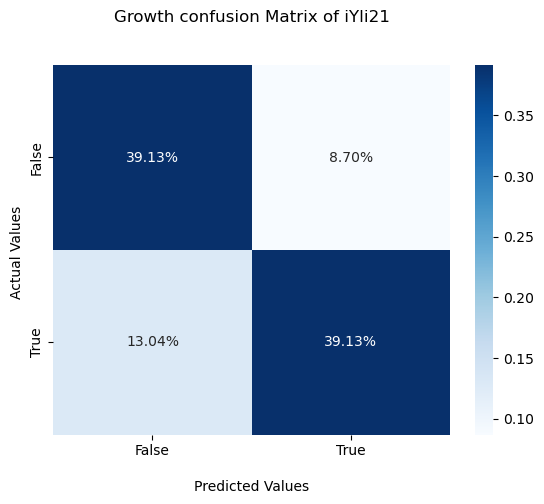

Sensitivity: 0.75
Specificity: 0.82
Negative Predictive Value: 0.75
Accuracy: 0.78


In [55]:
plot_confision_matrix(growth_simulation, model_name)


### iYali4

In [ ]:
## load model

## check if default growth is easy to restrict

## search for exchange reactions
empty_growth_dict = {
    'alkanes': ('', ''),
    'arabinitol': ('', ''),
    'L-arabinose': ('', ''),
    'D-arabinose': ('', ''),
    'citrate': ('', ''),
    'D-galactose': ('', ''),
    'D-glucosamine': ('', ''),
    'D-glucose': ('', ''),
    'ethanol': ('', ''),
    'fatty acids': ('', ''),
    'glycerol': ('', ''),
    'lactate': ('', ''),
    'L-sorbose': ('', ''),
    'maltose': ('', ''),
    'melibiose': ('', ''),
    'myo-inositol': ('', ''),
    'ribose': ('', ''),
    'succinate': ('', ''),
    'sucrose': ('', ''),
    'TAG': ('', ''),
    'trehalose': ('', ''),
    'xylitol': ('', ''),
    'xylose': ('', ''),
}